In [1]:
from module import *

import plotly.express as px
import matplotlib.pyplot as plt

import cv2
from matplotlib import pyplot as plt

import time

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import torch.optim as optim

C:\Users\coco8\anaconda3\envs\safranproject\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pickle

# Ouvre le fichier en mode lecture binaire
with open('../../results23022023.pickle', 'rb') as f:
    # Utilise pickle.load() pour charger les variables à partir du fichier
    my_variables = pickle.load(f)

# Les variables sont maintenant stockées dans le dictionnaire my_variables
# Vous pouvez accéder à chaque variable comme ceci :
training_dico_result_adam = my_variables["training_dico_result_adam"]
training_dico_result_SGD = my_variables["training_dico_result_SGD"]
training_dico_result_SGD_with_scheduler = my_variables["training_dico_result_SGD_with_scheduler"]
training_dico_result_adam_with_scheduler = my_variables["training_dico_result_adam_with_scheduler"]

## Abstract

Safran Electronics & Defense is developing a multi-target detection, classification, tracking and localization video chain for land, sea and airborne defence applications to assist operators in their missions.

This video chain can be deployed in the context of directional sights, handheld cameras, panoramic surveillance sights, or distributed wide field sensors. 

Safran Electronics & Defense wishes to optimize the valorization of its image & video database, which is heterogeneous, both in terms of content (type of campaign air, land, sea, type of sensor, associated metadata of navigation, image content, etc etc) and in terms of form (file format).

As part of this data enhancement, our team has implemented a context classification module. Thus, we studied different pre-trained classification models, which we re-trained for landscape and natural context recognition. This classification module is able to identify one of the following five landscapes in an image: Forest, Mountain, Ice, Coastal or Desert.

## Introduction

As part of our annual INFONUM project, we are partnering with the company SAFRAN.
 
Thus, within the framework of this project, we have to set up an architecture for extracting metadata each time a new file is added to the storage server. This architecture includes different bricks (extraction module, database, GUI, etc.) and notably AI bricks. Our partner gave us the freedom to choose what we would like to implement and we chose to work on a Deep Learning module allowing us to classify the contexts to which the imported images could belong (aerial, rural, maritime, desert, mountainous context).
 
Having seen that it was possible to couple the project of the Deep Learning module with the project of another course requiring a Deep Learning part, we thus made the choice to link these two projects.
 
The team is composed of two students: LEVY Daniel and PUJOL Corentin. As I stated above, we want to implement and compare different Deep Learning approaches to extract the context of different images. The objective would be to implement different models (ResNet, MobileNet, VGG for example) and to study their hyperparameters in order to obtain the best possible results on context extraction. The data used will be those proposed by the partner. As the partner has not yet provided us with the data, we have found several sources allowing us to start working with a dataset obtained from the Kaggle platform. 
 
The approach we would like to take would be to implement different pre-trained models, then to perform Transfer Learning (with and without fine-tuning) in order to make these models perform well on our data.

## Dataset presentation

This is Landscape classification dataset. This data consists of 5 different classes. Each class representing a kind of landscape. These classes are :

    Coast
    This class contains images belonging to coastal areas, or simply beaches.

    Desert
    This class contains images of desert areas such as Sahara Thar, etc.

    Forest
    This class is filled with images belonging to forest areas such as Amazon.

    Glacier
    This class consists of some amazing white images, These images belongs to glaciers. For example, the Antarctic.

    Mountains
    This class shows you the world from the top i.e. the mountain areas such as the Himalayas.
    
This data is first divided into 3 sub directories. These sub directories are the training, validation, and testing data directories. Another directory of tensorflow records is also added, which is further divided into 3 directories of training, validation and testing data, containing the tensorflow records of these images. This allow you to load the data both using Image Data Generator, or using the tensorflow records.

From my perspective for any. For any model to perform well on this data set, the model should have proper knowledge of the colors and the geometry of the image. Because when both the colors and geometry come together, they make up a landscape.

### Example of images from our dataset

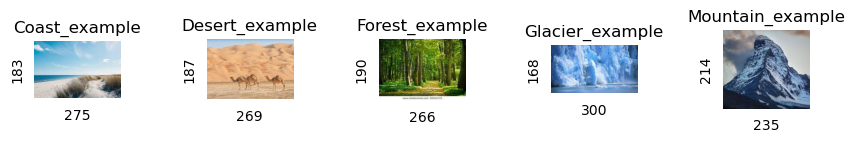

In [3]:
# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 1
columns = 5
  
# reading images example
path_example = "Images_example/"

cpt = 1
for image in os.listdir(path_example):
    img = cv2.imread(path_example + image)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #because OpenCV uses BGR as its default colour order for images, matplotlib uses RGB
    
    ax = fig.add_subplot(rows, columns, cpt)

    # showing image
    ax.imshow(RGB_img)
    
    ax.set_xlabel(img.shape[1])
    ax.set_ylabel(img.shape[0])
    
    # Turn off the axis lines and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
    ax.set_title(image.split('.')[0])
    cpt+=1

fig.subplots_adjust(wspace=1)
plt.show()


As we can see the images in the dataset have the same order of magnitude but in order to give them to our model for training we need to resize them identically. To do this, we will choose to resize them to the 256 x 256 pixels. The shape will be (256, 256, 3) because of the RGB color.

### Classes and distribution study

In [4]:
# List all Data Paths
train_path = "../../Data/Training Data/"
valid_path = "../../Data/Validation Data/"
test_path =  "../../Data/Testing Data/"

In [5]:
# Class Names
class_names = sorted(os.listdir(train_path))
n_classes = len(class_names)

# Show
print(f"Number of Classes : {n_classes}\nClass names : {class_names}")

Number of Classes : 5
Class names : ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']


In [6]:
# Class Distribution
class_dis = [len(os.listdir(train_path + name)) for name in class_names]


# Visualize
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

In [7]:
# Class Distribution
class_dis = [len(os.listdir(valid_path + name)) for name in class_names]


# Visualize
fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

In [8]:
# Class Distribution
class_dis = [len(os.listdir(test_path + name)) for name in class_names]


# Visualize
fig = px.pie(names=class_names, values=class_dis, title="Testing Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

fig = px.bar(x=class_names, y=class_dis, color=class_names)
fig.show()

The training, validation and testing data, all have equal class distribution. This make sure that the model will be fairly trained, validated and tested.

## Our approach to the problem

In order to succeed in determining the best performing model, we will load the infrastructures of four well-known models, already performing well on more global data sets. The objective is to re-train these models on the data of our problem.

We will divide the training phase into several steps in order to study each hyperparameter, understand how they work and finally choose the ones that will make the models perform best with respect to our initial problem.

After loading the pre-trained architectures, in order to avoid any fine-tuning of the first layers of the network, the gradients of the corresponding parameters must be frozen. Then, in order to perform the learning transfer, we will replace the last classification layer by the one appropriate to our problem. Thus, our prediction layer will be trained on our new data based on the performance of the previous layers already pre-trained. Once this step is completed, we will proceed to a fine-tuning step, in order to adjust the parameters of all the layers of our models.

To do so, we will define the cost function adapted to the problem and we will first apply the gradient descent
to the parameters of the newly defined fully connected layer only, with the different hyperparameters chosen. We will compare the performance of the model according to the chosen hyperparameters in order to determine which ones are the most suitable for training our models.

After training the new fully connected layer, we will untrain the upper layers of the model in the fine-tuning stage. We will follow the same approach as in the transfer learning step in order to make our models as efficient as possible.

We assume that some hyperparameters do not have the same effect depending on the architecture they are applied to, so we expect to get very good results on the different models but with different chosen hyperparameters.

### Selected pre-trained models

Resnet18, MobileNet, AlexNet, VGG16

### Hyperparameters studied

Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates (read more about hyperparameter tuning)

We define the following hyperparameters for training:

- Number of Epochs - the number times to iterate over the dataset

    Use of early stopping to record only the best and not the last model (recording only when the loss decreases)

- Batch Size - the number of data samples propagated through the network before the parameters are updated

    Try [16, 32, 64, 128, 256] but in fact, smallers should be better according some research (https://reader.elsevier.com/reader/sd/pii/S2405959519303455?token=C37354B4B0DEA9791B9005F04612342318223AC16CAF73061D563AC0CF8937F435433C40BB033FEBDFA6AF09F4C5A4FB&originRegion=eu-west-1&originCreation=20230216143607)
    
- Learning Rate - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

    How to adjust learning rate

    torch.optim.lr_scheduler provides several methods to adjust the learning rate based on the number of epochs. torch.optim.lr_scheduler.ReduceLROnPlateau allows dynamic learning rate reducing based on some validation measurements.

    Learning rate scheduling should be applied after optimizer’s update; e.g., you should write your code this way:

    Example:

        model = [Parameter(torch.randn(2, 2, requires_grad=True))]

        optimizer = SGD(model, 0.1)

        scheduler = ExponentialLR(optimizer, gamma=0.9)

        for epoch in range(20):

            for input, target in dataset:

                optimizer.zero_grad()
                output = model(input)
                loss = loss_fn(output, target)
                loss.backward()
                optimizer.step()

            scheduler.step()

### Loss function

The loss (or loss function) is used to measure how far your model predictions are from the true labels of your training data. It is calculated by comparing the outputs of your model with the true labels for a given training set.

The loss is then used to calculate the gradient of the cost function with respect to the model weights, which are then updated via the optimiser to minimise the loss. Thus, the lower the loss, the better the performance of your model.

To resolve our classification task, we choose the Cross Entropy Loss which is the most appropriate.

Indeed, Cross Entropy Loss is a cost function commonly used for classification problems. It is based on the principle of maximising the log-likelihood for the correct class. It measures the distance between the probability distribution predicted by the model and the actual distribution of classes. Indeed, the Cross Entropy Loss function is more sensitive to erroneous predictions, which can help to speed up convergence and achieve better classification performance.

You could also point out that Cross Entropy Loss is easy to compute and optimise using standard error back-propagation methods and is implemented in many Deep Learning frameworks, which allows for easy and fast implementation.

### Optimizer 

Optimization is the process of adjusting model parameters to reduce model error in each training step. Optimization algorithms define how this process is performed.  All optimization logic is encapsulated in the optimizer object. Here, we use the SGD optimizer; additionally, there are many different optimizers available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model’s parameters that need to be trained, and passing in the learning rate hyperparameter.

Example with SGD algorithm: 

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Link to see all the existing algorithms (SGD, Adagrad, RMSProp, Adam, NAdam, etc...) : https://pytorch.org/docs/stable/optim.html

The different optimizers can be divided in two families: gradient descent optimizers and adaptive optimizers. This division is exclusively based on an operational aspect which forces you to manually tune the learning rate in the case of Gradient Descent algorithms while it is automatically adapted in adaptive algorithms — that’s why we have this name.

    Gradient Descent:

    Batch gradient descent
    Stochastic gradient descent
    Mini-batch gradient descent
    
    Adaptive:

    Adagrad
    RMSprop
    Adam 
    
https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e

In [9]:
# adagrad = optim.Adagrad(model.parameters())
# adam = optim.Adam(model.parameters())
# RMSprop = optim.RMSprop(model.parameters())
#SGD = optim.SGD(model.parameters())
# optimizer_list = []

### Regularization

Regularization techniques are used to prevent overfitting by adding a penalty to the model's loss function. Some common regularization techniques include weight decay (L2 regularization), dropout, and batch normalization.

We can try also data augmention, if it can help us to reach better result.

## Experiences

We will start by loading our data, and applying some transformations to increase the performance of our models:

    First of all, we perform the resizing mentioned above, in 256 by 256
    
    Next, we transform the image into a tensor so that the data can be manipulated by the PyTorch library
    
    Finally, the Normalize transformation is used to normalise the pixel values of the images. mean and std are the mean and standard deviation of the pixel values of the images on the training dataset. These two values are used to centre the data around zero and scale it. To determine the values of mean and std, we need to calculate the mean and standard deviation of the pixel values of all the images in our training dataset.

### Data processing & loading datasets

In [10]:
# Transformation 
data_transforms = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor()])

# Loading datasets
train_dataset = ImageFolder(train_path, transform=data_transforms)

# Calculer les moyennes et écarts-types du dataset d'entraînement seulement
mean, std = compute_mean_std(train_dataset)

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4678, 0.4885, 0.4643])
Std: tensor([0.2229, 0.2048, 0.2261])


Here is the dataset function that we define in module.py. This function allow us to load correctly all our data from the directory to three variables : dataset_train, dataset_val, dataset_test. These variables allow us to handle easily our images and to give it to our different pretrained models. 

In [11]:
data_transforms = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset_train, dataset_val, dataset_test = dataset(data_transforms, train_path, valid_path, test_path)

We have to define our batch_size, for now it will be 40 but when the code will run perfectly we could begin to change it in order to study the difference of performance.

In [12]:
batch_size = 40 

loader_train = loader(dataset_train, batch_size, shuffle = True, num_workers=0)

In [13]:
# on utilisera le GPU (beaucoup plus rapide) si disponible, sinon on utilisera le CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu") # forcer en CPU s'il y a des problèmes de mémoire GPU (+ être patient...)
print("GPU available : ",torch.cuda.is_available())
if torch.cuda.is_available():
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

GPU available :  True
__CUDNN VERSION: 8302
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 3060 Laptop GPU
__CUDA Device Total Memory [GB]: 6.441926656


### Loading of the pretrained models

In [14]:
# my_models = loading_models()

    VGG16:

VGG16 is a deep convolutional neural network (CNN) model widely used in computer vision. It was proposed by Simonyan and Zisserman in 2014 at the ImageNet Large Scale Visual Recognition Challenge (ILSVRC).

The architecture of VGG16 consists of 16 layers, with convolutional layers stacked on top of each other in a simple and regular structure. Specifically, the VGG16 architecture consists of 13 convolutional layers and 3 fully connected layers (or FC), followed by a softmax function for classification. The convolutional layers use small filters (3x3) with a step size of 1, fills of 1 and ReLU activation functions, followed by a max clustering layer. The FC layers act as a final classification layer that takes the image features and predicts the corresponding object classes.

The VGG16 architecture is often used for image classification in tasks such as object recognition and object detection. Its simple and regular structure makes it easy to understand and modify the architecture to accommodate different types of data and computer vision tasks.


    ResNet-18:

The ResNet-18 model is a deep convolutional neural network (CNN) that was introduced in 2015 by He et al. in their paper "Deep Residual Learning for Image Recognition". ResNet-18 is a member of the ResNet family of models, which are known for their residual architecture that allows them to better handle vanishing gradient problems when training very deep neural networks.

ResNet-18 has a relatively simple but very effective architecture. It has 18 convolution and pooling layers, followed by a fully connected layer for classification. The model takes as input images of size 224x224 and can classify these images into 1000 different categories. The special feature of ResNet's residual architecture is that it allows for a direct transition from the input information to the output layers, by adding skip connections that bypass certain layers.

ResNet-18 is particularly useful for image classification, but can also be used for other computer vision tasks such as object detection or image segmentation. Because of its relative simplicity compared to other state-of-the-art models such as VGG or Inception, ResNet-18 is also faster to train and evaluate.


    AlexNet:
    
AlexNet is a deep convolutional neural network model developed by Alex Krizhevsky, Ilya Sutskever and Geoffrey Hinton in 2012. It was the first model to win the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012, with a classification error of only 15.3%, a significant improvement over previous models.

AlexNet's architecture consists of eight layers, including five convolution layers and three fully connected layers. The first layer is a convolution layer with an 11x11 core and a 4 stride, followed by a ReLU function and a 3x3 pooling layer. The following layers are similar, alternating convolution layers, ReLU functions and pooling layers.

The last three layers are fully connected layers, with a first layer of 4096 neurons, followed by two layers of 4096 neurons each. The last layer is a classification layer with as many neurons as the number of classes to be predicted.

AlexNet is often used for image classification tasks, especially in areas such as facial recognition, object detection, pattern recognition and image segmentation.


    MobileNetV2:

The MobileNetV2 model is a convolutional neural network (CNN) model designed to be very efficient in terms of computational power and model size, while providing good image classification performance. It was introduced by Google in 2018.

MobileNetV2's architecture features deep convolution blocks and bottleneck blocks that allow for high parameter reduction, while maintaining high classification accuracy. The model also uses group normalisation layers, deep weighting layers and residual connections to improve learning stability.

MobileNetV2 is mainly used for image classification on tasks such as object recognition, object detection, semantic segmentation, etc.

### First performance without Transfer Learning

To begin our experiences, we will try to use directly the differents pretrained models, in order to watch their performance without transfer learning. Thus, we could see the effect of the different transfer learning steps and see how the models improve their ability to classify landscapes.

We put the four models into evaluation mode in order to make all predictions on the test dataset.

In our case, all classes are balanced and each class is represented equally as we have seen in the presentation of our data. Thus accuracy, which represents the number of correct predictions of the model divided by the total number of predictions made, is an appropriate metric to evaluate the performance of our model. Indeed, it will measure the ability of the model to correctly predict the different classes equally. If the classes were not balanced, it would have been necessary to use other metrics such as precision, recall or F1-score to better assess the performance of the model.

In [15]:
# my_models = output_layer_adaptation(my_models, n_classes) # All models have now a new fc layer allowing to predict 

# without_TL_result = {}
# # Put the models in evaluation mode
# for model in my_models:
#     model.eval()
    
#     # Make predictions on test set
#     predictions = []
#     labels = []

#     start_time = time.time()
#     with torch.no_grad():
#         for inputs, target in dataset_test:
#             inputs = inputs.unsqueeze(0)
#             output = model(inputs)
#             _, pred = torch.max(output.data, 1)
#             predictions.append(pred.item())
#             labels.append(target)

#     # Calculer la précision de classification
#     accuracy = accuracy_score(labels, predictions)
#     print("Accuracy:", accuracy)

#     # Mesurer le temps d'inférence
#     inference_time = time.time() - start_time
#     print("Inference time:", inference_time, "seconds")
#     without_TL_result[model.__class__.__name__] = {"Accuracy":accuracy, "Inference time":inference_time}

Here is thus, the models performance without any training on the test set containing 500 images (100 images of each class):

| Modèles | Temps d'inférence (s) | Accuracy |
|--------|----------------------|-----------|
| resnet18 | 21.46 | 0.216 |
| mobilenet | 19.50 | 0.142 |
| vgg16 | 112.38 | 0.204 |
| alexnet | 10.64 | 0.266 |

The accuracies are very low but it's normal, the models have a new prediction layer which has not been trained before. Then, despite the models have usually high performance, we have to make transfer learning in order to improve and take advantage of the pretrained models performance. 

### Transfer Learning

We are going now to begin the Transfer learning with fine tunning step and the experiences in studying the listed above hyperparameters.

Link on interesting Transfer Learning course: 

https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

#### Freeze Early layers

We freeze all of the existing layers in the network by setting requires_grad to False.

In [16]:
# # Freeze early layers
# for model in my_models:
#     for param in model.parameters():
#         param.requires_grad = False
        
# my_models = output_layer_adaptation(my_models, n_classes) #We put the new classifying layers        

As we say, above in the loss function presentation, we have decided to use the Cross Entropy Loss:

In [17]:
criterion = nn.CrossEntropyLoss()

#### Transfer learning with SGD & Adam optimizer

We will compare the first step of tranfer learning on two basics optimizer :

One gradient descent and one adaptative which will be SGD and Adam. We leave the default settings in order to study how the training works and to see afterwards what happens and if it is possible to improve the training with some modifications. 

##### Adam optimizer

In [18]:
# training_dico_result_adam = {}
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for model in my_models:
#     print("Training of " + model.__class__.__name__)
#     model.to(device)
#     file_name = str(model.__class__.__name__+"_Adam.pt")
#     optimizer = optim.Adam(model.parameters())
    
#     model, history, inference_time = train_model(
#         model,
#         loader_train,
#         dataset_val,
#         optimizer,
#         criterion,
#         device,
#         file_name,
#         n_epochs=10)
#     training_dico_result_adam[model.__class__.__name__] = {"model":model, "history":history, "time": inference_time}

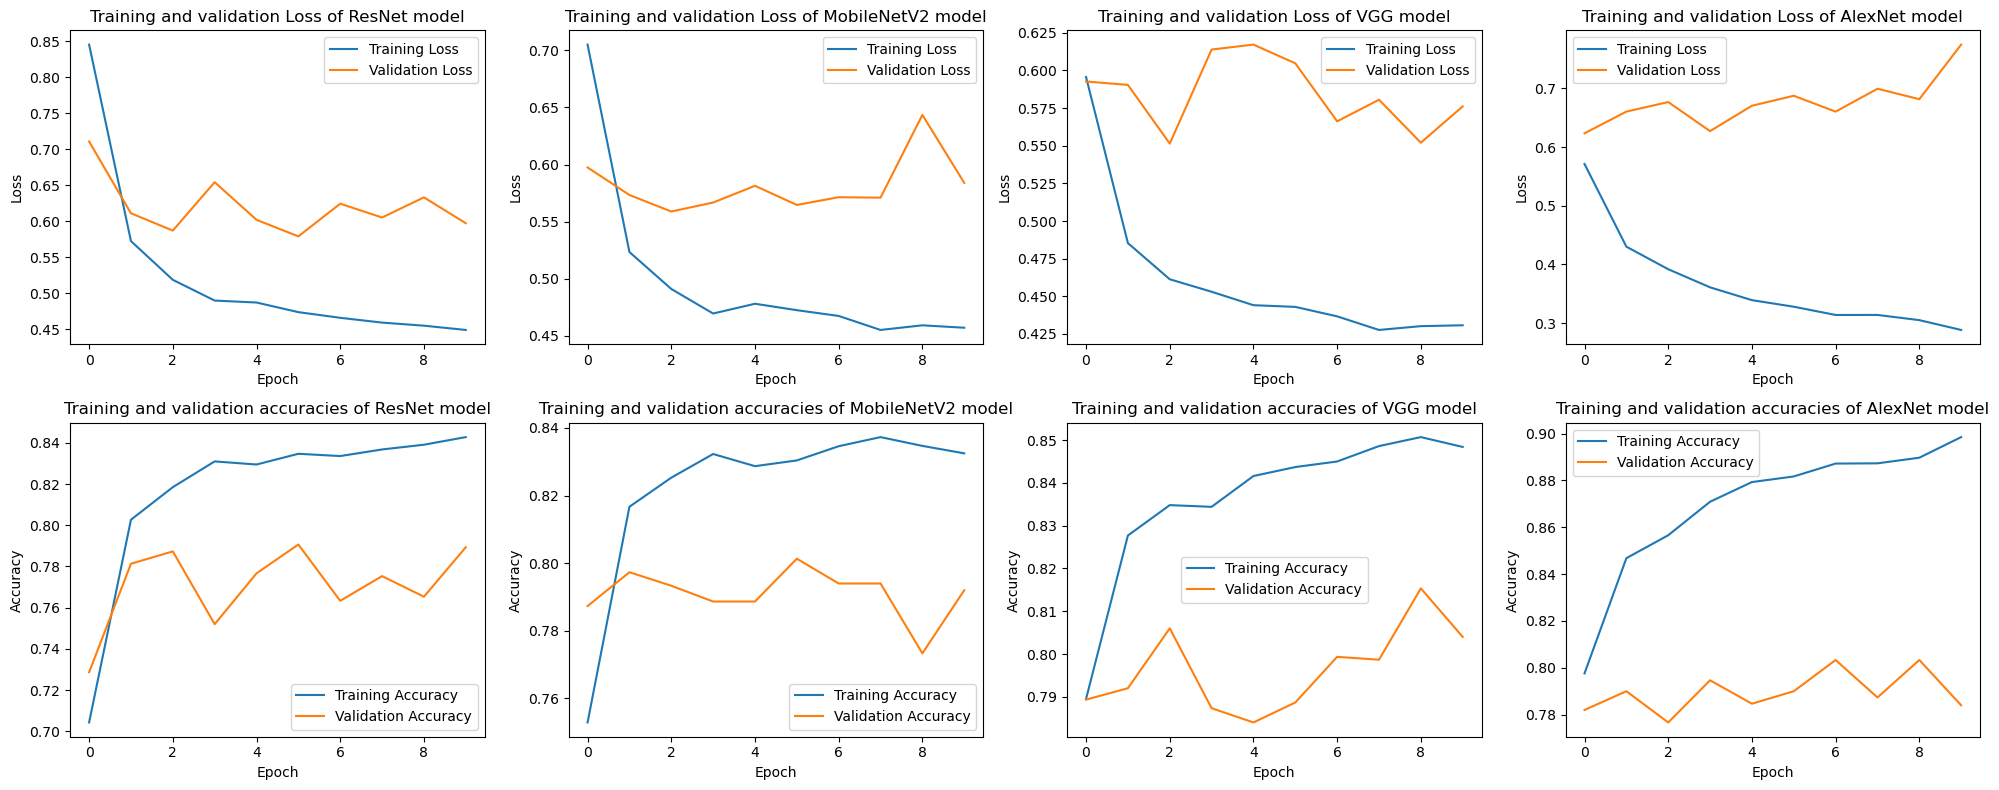

In [19]:
performance_curve(training_dico_result_adam, 10)

In [20]:
affichage_performance(training_dico_result_adam)

       Modèles  Accuracy  Inference time  Total number of parameters
0       ResNet  0.790667      370.796744                    11179077
1  MobileNetV2  0.793333      374.063680                     2230277
2          VGG  0.806000      855.969936                   134281029
3      AlexNet  0.782000      370.303783                    57024325


##### SGD Optimizer

In [21]:
# my_models = loading_models()

# # Freeze early layers
# for model in my_models:
#     for param in model.parameters():
#         param.requires_grad = False
        
# my_models = output_layer_adaptation(my_models, n_classes) #We put the new classifying layers   

# training_dico_result_SGD = {}
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for model in my_models:
#     print("Training of " + model.__class__.__name__)
#     model.to(device)
#     file_name = str(model.__class__.__name__+"_SGD.pt")
#     optimizer = optim.SGD(model.parameters(), lr=0.01)
    
#     model, history, inference_time = train_model(
#         model,
#         loader_train,
#         dataset_val,
#         optimizer,
#         criterion,
#         device,
#         file_name,
#         n_epochs=10)
#     training_dico_result_SGD[model.__class__.__name__] = {"model":model, "history":history, "time": inference_time}

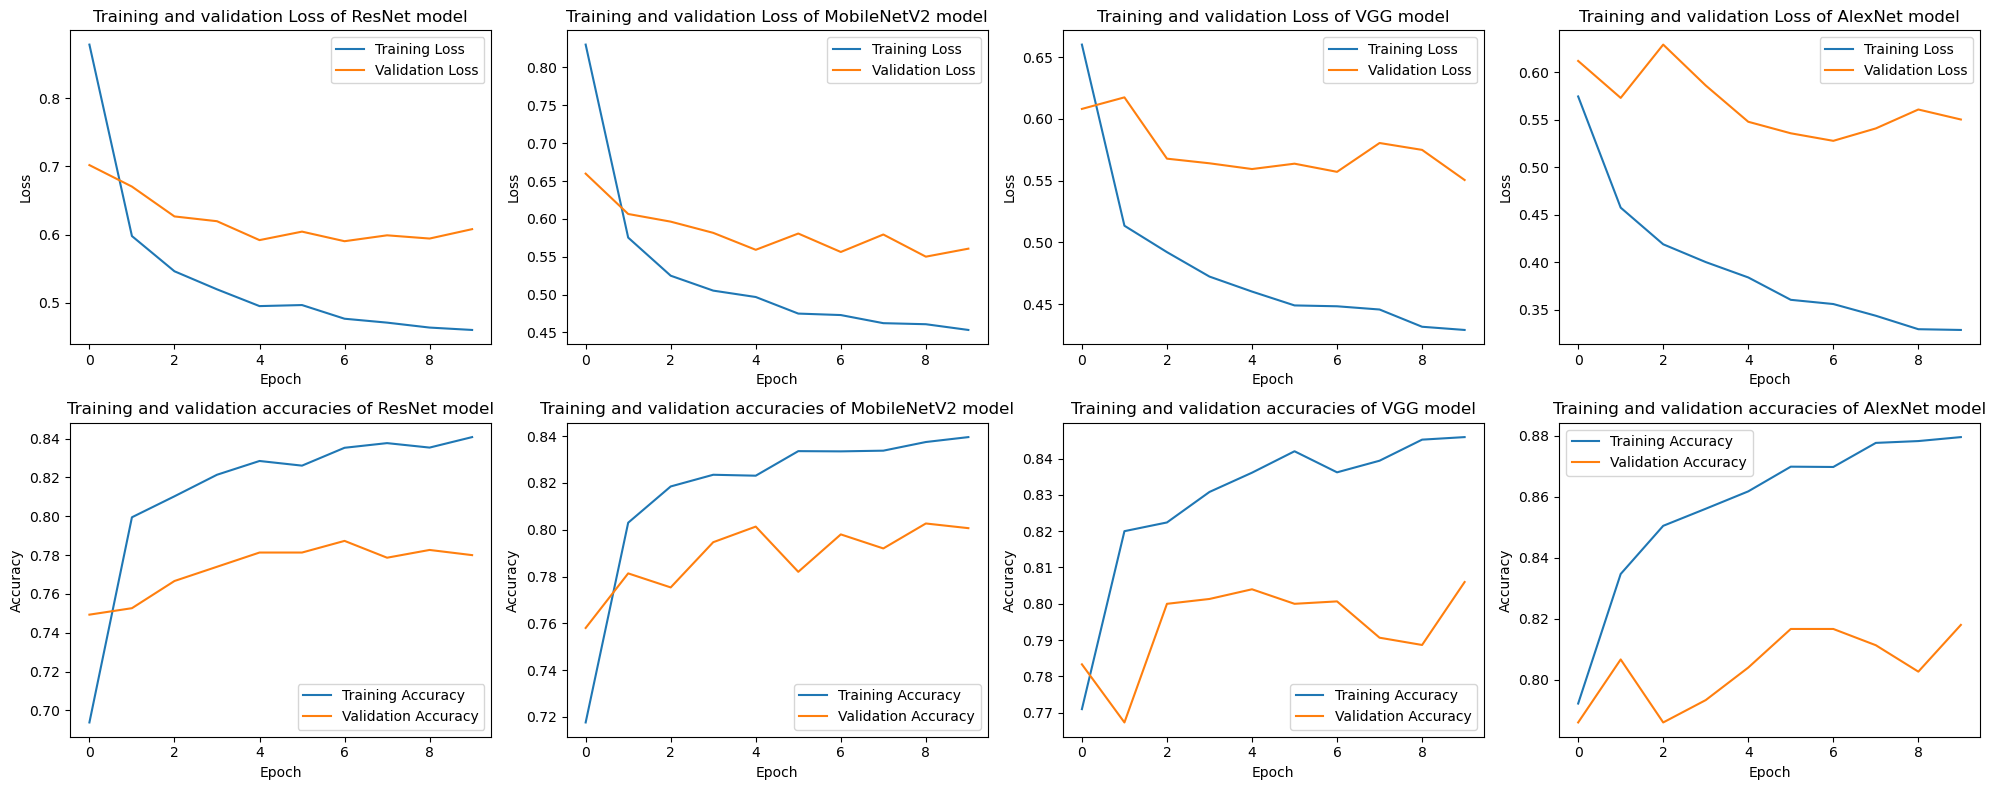

In [22]:
performance_curve(training_dico_result_SGD, 10)

In [23]:
affichage_performance(training_dico_result_SGD)

       Modèles  Accuracy  Inference time  Total number of parameters
0       ResNet  0.787333      372.136650                    11179077
1  MobileNetV2  0.802667      374.301679                     2230277
2          VGG  0.806000      856.364979                   134281029
3      AlexNet  0.816667      365.326119                    57024325


From this first training, we can note many things. Indeed, we can observe on the different graphs that the validation and training curves separate quite quickly, which is characteristic of overfitting. It is quite normal that the new classification layer overfits quickly during the learning transfer. This is due to the fact that the new layer is initially untrained, so it quickly learns the specific features of the new data set. 

To avoid overfitting, we will use regularisation techniques such as L1/L2 regularisation, dropout or data augmentation.

Despite the overfitting, we can however point out that the ResNet18 and MobileNetV2 models seem to perform the best, especially with the SGD optimizer, even though the accuracy values are slightly lower than the other models that overfit completely.

We also observe slight stability problems as the values oscillate quite easily. 

In the rest of our experiments, we will have to solve the two problems identified here:

    1) Management of overfitting
    
    2) Management of the stability of the training

#### Management of overfitting

Modifying the new classification layer can help avoid overfitting, as it is the last layer in the network and is responsible for the final prediction. Here are some changes we can make to the classification layer to avoid overfitting:

Add a regularisation: Adding an L1 or L2 regularisation to the classification layer to reduce the large weights in the layer. This can help reduce overfitting by limiting the complexity of the model.

Add Dropout: Adding Dropout to the classification layer to prevent the model from overfitting the training data. Dropout randomly disables neurons in the classification layer during training, preventing the model from overfitting to the training data.

Use a different activation function: Using of a different activation function for the classification layer. For example, we could try to use a ReLU activation function or a LeakyReLU activation function rather than a sigmoid activation function.

#### Management of the stability

To improve the stability of the training we can try the following manipulations:

Adjust the learning rate: If the learning rate is too high, the model parameters may "jump" from one optimal region to another, leading to large variations in loss and accuracy. In this case, you can try to reduce the learning rate to stabilise the training.

Use a scheduler: A scheduler allows you to adjust the learning rate as the training progresses. For example, the learning rate can be reduced each time the loss stagnates or the accuracy does not improve for a number of epochs. This can help to avoid unstable variations.

Increase the amount of data: If the amount of training data is low, the model may overfit the training data, leading to instability in loss and accuracy. In this case, you can try to increase the amount of training data by using data augmentation techniques, such as rotation, translation or symmetry.

#### Modification of the classification layer by adding some elements to adjust the management of overfitting and learning stability

As a first step, we decided to change our classification layer which was too simple (it was a single nn.Linear layer). We replaced this classification layer with the following structure:

    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(p=dropout_prob),
    nn.Linear(256, num_classes)
    
This is a first linear layer that takes as input num_ftrs (the output number of the previous layer of the network) and outputs 256 features. In the context of deep learning, these features can be thought of as learned attributes that represent important characteristics of the data.

We then add a non-linear ReLU activation layer. This function takes as input the results of the previous linear layer and applies a non-linear function to produce non-linear outputs. This helps the model learn non-linear representations of the data.

nn.Dropout(p=dropout_prob): As mentioned earlier, we also add a dropout layer which is a technique to prevent overlearning. This layer randomly removes some of the neurons from the previous layer with a probability of dropout_prob, which forces the model to learn more robust features that are less dependent on certain neurons. In our features, we chose a probability of 0.3 to determine whether a neuron would be disabled or not. Then the structure ends with another linear layer that takes as input the outputs of the previous layer and produces final outputs corresponding to the number of classes to be predicted (num_classes).

Overall, this sequence creates a so-called "fully connected" layer (fc) that takes the features learned by the previous model and transforms them into an output that corresponds to the classes to be predicted. 

In addition, we add L2 regularisation to all parameters of the fully connected layer (fc) of our models.

We recall that the L2 regularisation consists in adding an extra term to the loss function which penalises the large weights of the model. This penalty, as mentioned above, limits the complexity of the model and prevents overfitting.

Finally we choose a ReduceLROnPlateau scheduler in order to adjust automatically the learning rate. The ReduceLROnPlateau scheduler is a learning rate scheduler in PyTorch that automatically adjusts the learning rate when the validation loss of the model stops improving. The scheduler monitors the validation loss and, when it stagnates for a certain number of epochs, it decreases the learning rate by a certain factor. In this way, it finds an optimal learning rate for a given model.

Our new classification layer being more complex than the previous one, we encountered memory problems when training the four models (Out of memory error). One way of dealing with this problem is to reduce the batch_size, which was initially set at 40. We will first reduce it to 20 in order to observe if the memory problems are solved:

In [24]:
batch_size = 20

loader_train = loader(dataset_train, batch_size, shuffle = True, num_workers=0)

In [25]:
my_models = loading_models()

# Freeze early layers
for model in my_models:
    for param in model.parameters():
        param.requires_grad = False
        
my_models = output_layer_adaptation(my_models, n_classes) #We put the new classifying layers   

training_dico_result_new_layer = {}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model in my_models:
    print("Training of " + model.__class__.__name__)
    model.to(device)
    file_name = str(model.__class__.__name__+"_SGD_scheduler.pt")
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    model, history, inference_time = train_model(
        model,
        loader_train,
        dataset_val,
        optimizer,
        criterion,
        device,
        file_name,
        scheduler,
        n_epochs=20)
    training_dico_result_new_layer[model.__class__.__name__] = {"model":model, "history":history, "time": inference_time}

Training of ResNet
EPOCH  0


100%|██████████| 500/500 [01:10<00:00,  7.07it/s]


499 loss train: 0.9589	 acc train: 0.6599	 loss val 0.6922	 Acc (val): 74.7%
ResNet_SGD_scheduler.pt saved: 0.6922292046844959 < inf
EPOCH  1


100%|██████████| 500/500 [00:43<00:00, 11.61it/s]


499 loss train: 0.6424	 acc train: 0.7687	 loss val 0.6115	 Acc (val): 78.1%
ResNet_SGD_scheduler.pt saved: 0.6115149082839489 < 0.6922292046844959
EPOCH  2


100%|██████████| 500/500 [00:43<00:00, 11.41it/s]


499 loss train: 0.5777	 acc train: 0.7911	 loss val 0.6231	 Acc (val): 76.9%
EPOCH  3


100%|██████████| 500/500 [00:42<00:00, 11.65it/s]


499 loss train: 0.5610	 acc train: 0.7972	 loss val 0.5936	 Acc (val): 78.3%
ResNet_SGD_scheduler.pt saved: 0.5936195858567953 < 0.6115149082839489
EPOCH  4


100%|██████████| 500/500 [00:45<00:00, 11.05it/s]


499 loss train: 0.5376	 acc train: 0.8122	 loss val 0.5832	 Acc (val): 78.5%
ResNet_SGD_scheduler.pt saved: 0.5831866276822985 < 0.5936195858567953
EPOCH  5


100%|██████████| 500/500 [00:40<00:00, 12.27it/s]


499 loss train: 0.5232	 acc train: 0.8127	 loss val 0.6112	 Acc (val): 77.6%
EPOCH  6


100%|██████████| 500/500 [00:43<00:00, 11.62it/s]


499 loss train: 0.5169	 acc train: 0.8151	 loss val 0.5719	 Acc (val): 79.1%
ResNet_SGD_scheduler.pt saved: 0.571896867711097 < 0.5831866276822985
EPOCH  7


100%|██████████| 500/500 [00:42<00:00, 11.74it/s]


499 loss train: 0.5047	 acc train: 0.8200	 loss val 0.5672	 Acc (val): 78.7%
ResNet_SGD_scheduler.pt saved: 0.5671608463451266 < 0.571896867711097
EPOCH  8


100%|██████████| 500/500 [00:43<00:00, 11.50it/s]


499 loss train: 0.4869	 acc train: 0.8265	 loss val 0.5659	 Acc (val): 79.6%
ResNet_SGD_scheduler.pt saved: 0.5658508704770356 < 0.5671608463451266
EPOCH  9


100%|██████████| 500/500 [00:42<00:00, 11.67it/s]


499 loss train: 0.4790	 acc train: 0.8312	 loss val 0.5987	 Acc (val): 78.1%
EPOCH  10


100%|██████████| 500/500 [00:40<00:00, 12.24it/s]


499 loss train: 0.4673	 acc train: 0.8327	 loss val 0.5606	 Acc (val): 79.5%
ResNet_SGD_scheduler.pt saved: 0.5606078350991011 < 0.5658508704770356
EPOCH  11


100%|██████████| 500/500 [00:43<00:00, 11.52it/s]


499 loss train: 0.4622	 acc train: 0.8343	 loss val 0.5752	 Acc (val): 78.5%
EPOCH  12


100%|██████████| 500/500 [00:43<00:00, 11.50it/s]


499 loss train: 0.4554	 acc train: 0.8328	 loss val 0.5772	 Acc (val): 79.5%
EPOCH  13


100%|██████████| 500/500 [00:43<00:00, 11.43it/s]


499 loss train: 0.4435	 acc train: 0.8381	 loss val 0.5630	 Acc (val): 79.5%
EPOCH  14


100%|██████████| 500/500 [01:07<00:00,  7.41it/s]


499 loss train: 0.4425	 acc train: 0.8391	 loss val 0.5798	 Acc (val): 78.9%
EPOCH  15


100%|██████████| 500/500 [00:42<00:00, 11.63it/s]


499 loss train: 0.4318	 acc train: 0.8467	 loss val 0.5427	 Acc (val): 80.0%
ResNet_SGD_scheduler.pt saved: 0.5426904183421284 < 0.5606078350991011
EPOCH  16


100%|██████████| 500/500 [00:42<00:00, 11.82it/s]


499 loss train: 0.4253	 acc train: 0.8459	 loss val 0.5551	 Acc (val): 79.9%
EPOCH  17


100%|██████████| 500/500 [00:42<00:00, 11.74it/s]


499 loss train: 0.4216	 acc train: 0.8487	 loss val 0.5635	 Acc (val): 79.1%
EPOCH  18


100%|██████████| 500/500 [01:03<00:00,  7.91it/s]


499 loss train: 0.4133	 acc train: 0.8509	 loss val 0.5281	 Acc (val): 81.1%
ResNet_SGD_scheduler.pt saved: 0.5281120412526652 < 0.5426904183421284
EPOCH  19


100%|██████████| 500/500 [00:43<00:00, 11.40it/s]


499 loss train: 0.4037	 acc train: 0.8570	 loss val 0.5577	 Acc (val): 79.3%
Training of MobileNetV2
EPOCH  0


100%|██████████| 500/500 [00:44<00:00, 11.17it/s]


499 loss train: 0.9407	 acc train: 0.6646	 loss val 0.6196	 Acc (val): 77.3%
MobileNetV2_SGD_scheduler.pt saved: 0.6196049392223358 < inf
EPOCH  1


100%|██████████| 500/500 [00:42<00:00, 11.67it/s]


499 loss train: 0.6171	 acc train: 0.7793	 loss val 0.5770	 Acc (val): 79.0%
MobileNetV2_SGD_scheduler.pt saved: 0.5769816916510463 < 0.6196049392223358
EPOCH  2


100%|██████████| 500/500 [00:42<00:00, 11.71it/s]


499 loss train: 0.5693	 acc train: 0.7931	 loss val 0.5559	 Acc (val): 79.2%
MobileNetV2_SGD_scheduler.pt saved: 0.5558683960214257 < 0.5769816916510463
EPOCH  3


100%|██████████| 500/500 [00:42<00:00, 11.71it/s]


499 loss train: 0.5537	 acc train: 0.7996	 loss val 0.5410	 Acc (val): 80.0%
MobileNetV2_SGD_scheduler.pt saved: 0.540958718072623 < 0.5558683960214257
EPOCH  4


100%|██████████| 500/500 [00:43<00:00, 11.44it/s]


499 loss train: 0.5364	 acc train: 0.8045	 loss val 0.5572	 Acc (val): 79.0%
EPOCH  5


100%|██████████| 500/500 [00:43<00:00, 11.47it/s]


499 loss train: 0.5213	 acc train: 0.8124	 loss val 0.5441	 Acc (val): 79.3%
EPOCH  6


100%|██████████| 500/500 [00:43<00:00, 11.62it/s]


499 loss train: 0.5146	 acc train: 0.8117	 loss val 0.5424	 Acc (val): 80.5%
EPOCH  7


100%|██████████| 500/500 [00:43<00:00, 11.49it/s]


499 loss train: 0.4938	 acc train: 0.8185	 loss val 0.5545	 Acc (val): 80.0%
EPOCH  8


100%|██████████| 500/500 [00:42<00:00, 11.69it/s]


499 loss train: 0.4855	 acc train: 0.8249	 loss val 0.5088	 Acc (val): 80.9%
MobileNetV2_SGD_scheduler.pt saved: 0.5087718683760614 < 0.540958718072623
EPOCH  9


100%|██████████| 500/500 [00:43<00:00, 11.57it/s]


499 loss train: 0.4938	 acc train: 0.8198	 loss val 0.5456	 Acc (val): 79.2%
EPOCH  10


100%|██████████| 500/500 [00:59<00:00,  8.43it/s]


499 loss train: 0.4823	 acc train: 0.8249	 loss val 0.5260	 Acc (val): 80.9%
EPOCH  11


100%|██████████| 500/500 [00:43<00:00, 11.42it/s]


499 loss train: 0.4831	 acc train: 0.8263	 loss val 0.5379	 Acc (val): 79.5%
EPOCH  12


100%|██████████| 500/500 [00:43<00:00, 11.62it/s]


499 loss train: 0.4608	 acc train: 0.8324	 loss val 0.5094	 Acc (val): 81.1%
EPOCH  13


100%|██████████| 500/500 [00:42<00:00, 11.78it/s]


499 loss train: 0.4618	 acc train: 0.8314	 loss val 0.5144	 Acc (val): 80.9%
EPOCH  14


100%|██████████| 500/500 [00:42<00:00, 11.64it/s]


499 loss train: 0.4566	 acc train: 0.8340	 loss val 0.5071	 Acc (val): 81.3%
MobileNetV2_SGD_scheduler.pt saved: 0.5070853321077302 < 0.5087718683760614
EPOCH  15


100%|██████████| 500/500 [00:42<00:00, 11.67it/s]


499 loss train: 0.4470	 acc train: 0.8354	 loss val 0.5313	 Acc (val): 79.8%
EPOCH  16


100%|██████████| 500/500 [00:42<00:00, 11.71it/s]


499 loss train: 0.4498	 acc train: 0.8322	 loss val 0.5276	 Acc (val): 80.3%
EPOCH  17


100%|██████████| 500/500 [00:43<00:00, 11.49it/s]


499 loss train: 0.4456	 acc train: 0.8375	 loss val 0.5417	 Acc (val): 79.7%
EPOCH  18


100%|██████████| 500/500 [00:42<00:00, 11.65it/s]


499 loss train: 0.4352	 acc train: 0.8449	 loss val 0.5282	 Acc (val): 80.3%
EPOCH  19


100%|██████████| 500/500 [00:45<00:00, 10.99it/s]


499 loss train: 0.4290	 acc train: 0.8467	 loss val 0.5202	 Acc (val): 81.3%
Training of VGG
EPOCH  0


100%|██████████| 500/500 [02:27<00:00,  3.38it/s]


499 loss train: 0.6889	 acc train: 0.7652	 loss val 0.6411	 Acc (val): 77.5%
VGG_SGD_scheduler.pt saved: 0.6411277332305908 < inf
EPOCH  1


100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


499 loss train: 0.4749	 acc train: 0.8433	 loss val 0.5416	 Acc (val): 81.0%
VGG_SGD_scheduler.pt saved: 0.5416349390745163 < 0.6411277332305908
EPOCH  2


100%|██████████| 500/500 [02:33<00:00,  3.25it/s]


499 loss train: 0.3923	 acc train: 0.8760	 loss val 0.5295	 Acc (val): 80.9%
VGG_SGD_scheduler.pt saved: 0.5295196988880634 < 0.5416349390745163
EPOCH  3


100%|██████████| 500/500 [02:30<00:00,  3.31it/s]


499 loss train: 0.3472	 acc train: 0.8905	 loss val 0.6156	 Acc (val): 78.8%
EPOCH  4


100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


499 loss train: 0.2975	 acc train: 0.9037	 loss val 0.5601	 Acc (val): 81.8%
EPOCH  5


100%|██████████| 500/500 [02:33<00:00,  3.25it/s]


499 loss train: 0.2663	 acc train: 0.9162	 loss val 0.5715	 Acc (val): 81.4%
EPOCH  6


100%|██████████| 500/500 [02:36<00:00,  3.19it/s]


499 loss train: 0.2435	 acc train: 0.9212	 loss val 0.5884	 Acc (val): 80.9%
EPOCH  7


100%|██████████| 500/500 [02:33<00:00,  3.25it/s]


499 loss train: 0.2231	 acc train: 0.9282	 loss val 0.6198	 Acc (val): 81.3%
EPOCH  8


100%|██████████| 500/500 [02:33<00:00,  3.26it/s]


499 loss train: 0.1987	 acc train: 0.9374	 loss val 0.6068	 Acc (val): 80.9%
EPOCH  9


100%|██████████| 500/500 [02:35<00:00,  3.21it/s]


499 loss train: 0.1890	 acc train: 0.9420	 loss val 0.6878	 Acc (val): 79.6%
EPOCH  10


100%|██████████| 500/500 [02:35<00:00,  3.21it/s]


499 loss train: 0.1774	 acc train: 0.9423	 loss val 0.6686	 Acc (val): 80.3%
EPOCH  11


100%|██████████| 500/500 [02:36<00:00,  3.20it/s]


499 loss train: 0.1722	 acc train: 0.9442	 loss val 0.6943	 Acc (val): 80.5%
EPOCH  12


100%|██████████| 500/500 [02:22<00:00,  3.51it/s]


499 loss train: 0.1562	 acc train: 0.9484	 loss val 0.7144	 Acc (val): 80.5%
EPOCH  13


100%|██████████| 500/500 [02:42<00:00,  3.08it/s]


499 loss train: 0.1556	 acc train: 0.9508	 loss val 0.6766	 Acc (val): 81.1%
EPOCH  14


100%|██████████| 500/500 [02:36<00:00,  3.19it/s]


499 loss train: 0.1344	 acc train: 0.9600	 loss val 0.7025	 Acc (val): 81.1%
EPOCH  15


100%|██████████| 500/500 [02:35<00:00,  3.21it/s]


499 loss train: 0.1218	 acc train: 0.9624	 loss val 0.7256	 Acc (val): 80.8%
EPOCH  16


100%|██████████| 500/500 [02:38<00:00,  3.15it/s]


499 loss train: 0.1136	 acc train: 0.9636	 loss val 0.7180	 Acc (val): 81.5%
EPOCH  17


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]


499 loss train: 0.1159	 acc train: 0.9662	 loss val 0.7301	 Acc (val): 81.1%
EPOCH  18


100%|██████████| 500/500 [02:35<00:00,  3.22it/s]


499 loss train: 0.1134	 acc train: 0.9650	 loss val 0.7367	 Acc (val): 81.2%
EPOCH  19


100%|██████████| 500/500 [02:18<00:00,  3.61it/s]


499 loss train: 0.1108	 acc train: 0.9668	 loss val 0.7367	 Acc (val): 80.9%
Training of AlexNet
EPOCH  0


100%|██████████| 500/500 [00:52<00:00,  9.59it/s]


499 loss train: 0.6012	 acc train: 0.7917	 loss val 0.6315	 Acc (val): 78.4%
AlexNet_SGD_scheduler.pt saved: 0.6314876802191138 < inf
EPOCH  1


100%|██████████| 500/500 [00:51<00:00,  9.79it/s]


499 loss train: 0.4761	 acc train: 0.8366	 loss val 0.5850	 Acc (val): 80.2%
AlexNet_SGD_scheduler.pt saved: 0.584958656091243 < 0.6314876802191138
EPOCH  2


100%|██████████| 500/500 [00:51<00:00,  9.72it/s]


499 loss train: 0.4639	 acc train: 0.8403	 loss val 0.6159	 Acc (val): 78.9%
EPOCH  3


100%|██████████| 500/500 [00:51<00:00,  9.77it/s]


499 loss train: 0.4601	 acc train: 0.8436	 loss val 0.5892	 Acc (val): 79.1%
EPOCH  4


100%|██████████| 500/500 [00:50<00:00,  9.89it/s]


499 loss train: 0.4367	 acc train: 0.8487	 loss val 0.6072	 Acc (val): 77.7%
EPOCH  5


100%|██████████| 500/500 [00:50<00:00,  9.84it/s]


499 loss train: 0.4192	 acc train: 0.8539	 loss val 0.5894	 Acc (val): 79.2%
EPOCH  6


100%|██████████| 500/500 [00:51<00:00,  9.77it/s]


499 loss train: 0.4015	 acc train: 0.8647	 loss val 0.5298	 Acc (val): 81.5%
AlexNet_SGD_scheduler.pt saved: 0.529830252174288 < 0.584958656091243
EPOCH  7


100%|██████████| 500/500 [00:50<00:00,  9.84it/s]


499 loss train: 0.3782	 acc train: 0.8710	 loss val 0.5637	 Acc (val): 79.4%
EPOCH  8


100%|██████████| 500/500 [01:42<00:00,  4.90it/s]


499 loss train: 0.3588	 acc train: 0.8769	 loss val 0.5642	 Acc (val): 81.1%
EPOCH  9


100%|██████████| 500/500 [00:45<00:00, 10.99it/s]


499 loss train: 0.3460	 acc train: 0.8819	 loss val 0.5829	 Acc (val): 81.0%
EPOCH  10


100%|██████████| 500/500 [00:45<00:00, 10.93it/s]


499 loss train: 0.3328	 acc train: 0.8842	 loss val 0.5744	 Acc (val): 80.5%
EPOCH  11


100%|██████████| 500/500 [00:44<00:00, 11.18it/s]


499 loss train: 0.3339	 acc train: 0.8858	 loss val 0.5998	 Acc (val): 81.1%
EPOCH  12


100%|██████████| 500/500 [00:44<00:00, 11.23it/s]


499 loss train: 0.3230	 acc train: 0.8876	 loss val 0.5502	 Acc (val): 82.6%
EPOCH  13


100%|██████████| 500/500 [00:44<00:00, 11.31it/s]


499 loss train: 0.3053	 acc train: 0.8939	 loss val 0.6154	 Acc (val): 80.6%
EPOCH  14


100%|██████████| 500/500 [00:44<00:00, 11.16it/s]


499 loss train: 0.3055	 acc train: 0.8957	 loss val 0.5399	 Acc (val): 81.9%
EPOCH  15


100%|██████████| 500/500 [00:44<00:00, 11.15it/s]


499 loss train: 0.2796	 acc train: 0.9043	 loss val 0.5992	 Acc (val): 80.7%
EPOCH  16


100%|██████████| 500/500 [00:46<00:00, 10.85it/s]


499 loss train: 0.2710	 acc train: 0.9072	 loss val 0.6059	 Acc (val): 80.9%
EPOCH  17


100%|██████████| 500/500 [00:45<00:00, 10.95it/s]


499 loss train: 0.2760	 acc train: 0.9047	 loss val 0.6135	 Acc (val): 80.5%
EPOCH  18


100%|██████████| 500/500 [00:45<00:00, 11.11it/s]


499 loss train: 0.2494	 acc train: 0.9150	 loss val 0.5991	 Acc (val): 81.7%
EPOCH  19


100%|██████████| 500/500 [00:45<00:00, 11.06it/s]


499 loss train: 0.2389	 acc train: 0.9196	 loss val 0.6005	 Acc (val): 82.0%


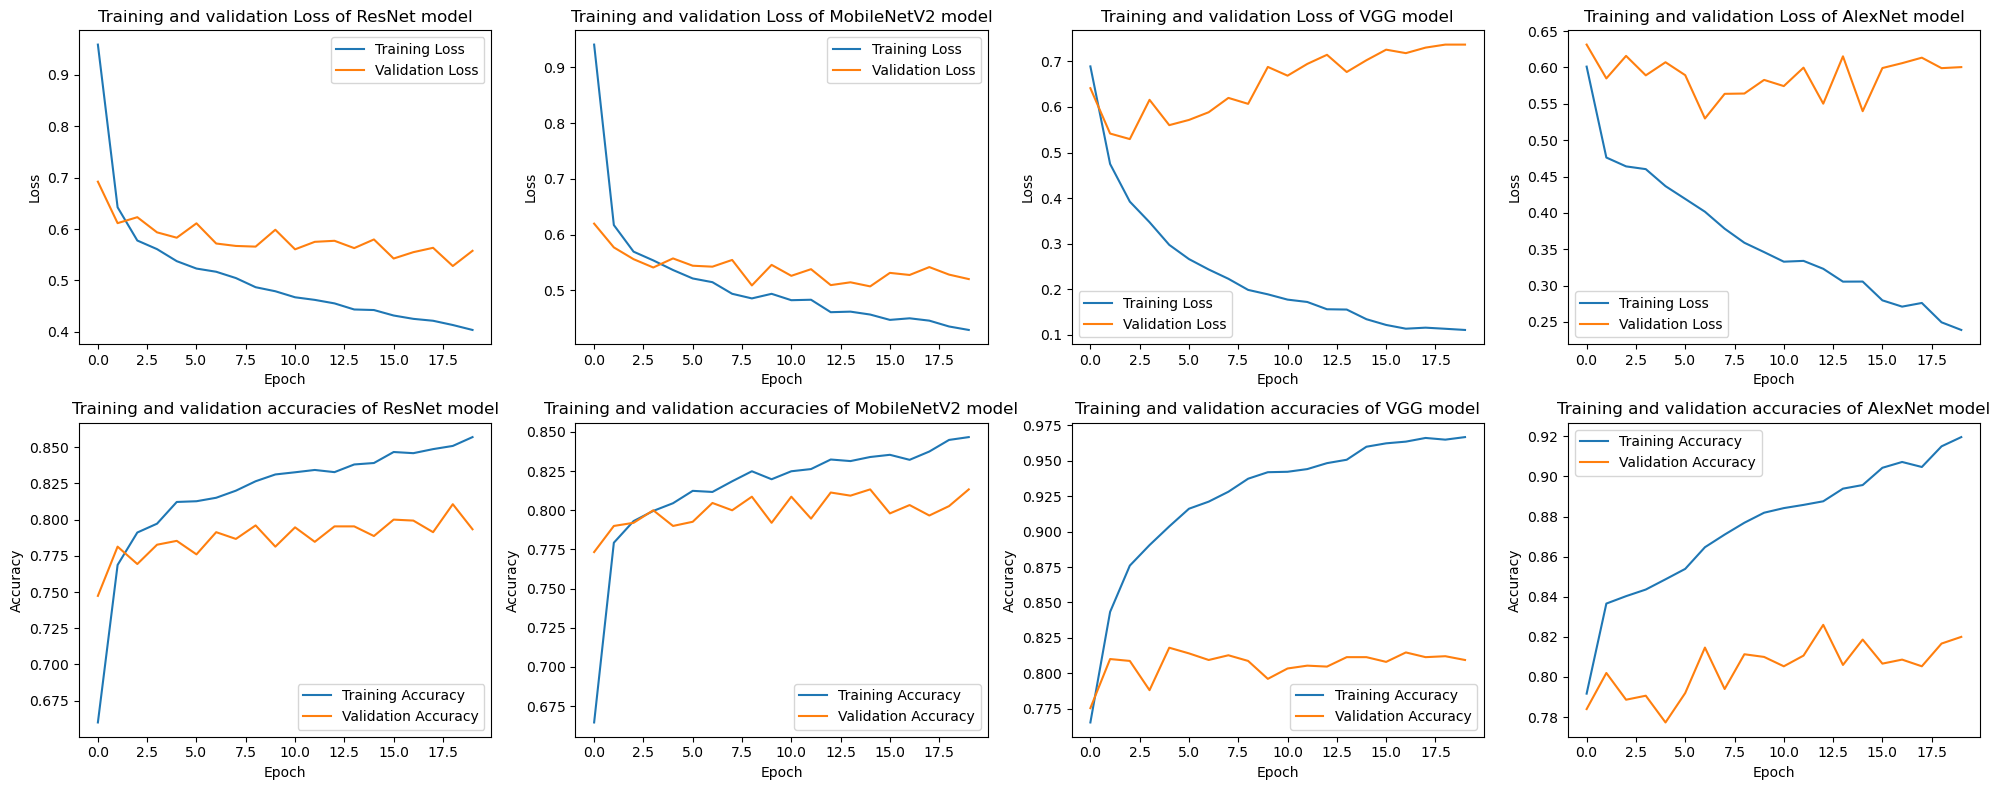

In [33]:
performance_curve(training_dico_result_new_layer, 20)

In [34]:
affichage_performance(training_dico_result_new_layer)

       Modèles  Accuracy  Inference time  Total number of parameters
0       ResNet  0.810667     1134.308365                    11309125
1  MobileNetV2  0.813333     1041.530416                     2553093
2          VGG  0.808667     3495.495873                   135310661
3      AlexNet  0.814667     1159.483064                    58053957


Using of a scheduler to adjust automatically the learning rate

In [26]:
# my_models = loading_models()

# # Freeze early layers
# for model in my_models:
#     for param in model.parameters():
#         param.requires_grad = False
        
# my_models = output_layer_adaptation(my_models, n_classes) #We put the new classifying layers   

# training_dico_result_SGD_with_scheduler = {}
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# for model in my_models:
#     print("Training of " + model.__class__.__name__)
#     model.to(device)
#     file_name = str(model.__class__.__name__+"_SGD_scheduler.pt")
#     optimizer = optim.SGD(model.parameters(), lr=0.01)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#     model, history, inference_time = train_model(
#         model,
#         loader_train,
#         dataset_val,
#         optimizer,
#         criterion,
#         device,
#         file_name,
#         scheduler,
#         n_epochs=10)
#     training_dico_result_SGD_with_scheduler[model.__class__.__name__] = {"model":model, "history":history, "time": inference_time}

In [27]:
# performance_curve(training_dico_result_SGD_with_scheduler, 10)

In [28]:
# affichage_performance(training_dico_result_SGD_with_scheduler)

In [29]:
# my_models = loading_models()

# # Freeze early layers
# for model in my_models:
#     for param in model.parameters():
#         param.requires_grad = False
        
# my_models = output_layer_adaptation(my_models, n_classes) #We put the new classifying layers   

# training_dico_result_adam_with_scheduler = {}
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# for model in my_models:
#     print("Training of " + model.__class__.__name__)
#     model.to(device)
#     file_name = str(model.__class__.__name__+"_Adam_scheduler.pt")
#     optimizer = optim.Adam(model.parameters())
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
#     model, history, inference_time = train_model(
#         model,
#         loader_train,
#         dataset_val,
#         optimizer,
#         criterion,
#         device,
#         file_name,
#         scheduler,
#         n_epochs=10)
#     training_dico_result_adam_with_scheduler[model.__class__.__name__] = {"model":model, "history":history, "time": inference_time}

In [30]:
# performance_curve(training_dico_result_adam_with_scheduler, 10)

In [31]:
# affichage_performance(training_dico_result_adam_with_scheduler)

In [32]:
# import pickle

# # Crée un dictionnaire pour stocker toutes vos variables
# my_variables = {"training_dico_result_adam":training_dico_result_adam,
#                 "training_dico_result_SGD":training_dico_result_SGD, 
#                 "training_dico_result_SGD_with_scheduler":training_dico_result_SGD_with_scheduler,
#                 "training_dico_result_adam_with_scheduler":training_dico_result_adam_with_scheduler
#                }

# # Ouvre un fichier en mode écriture binaire
# with open('results23022023.pickle', 'wb') as f:
#     # Utilise pickle.dump() pour écrire les variables dans le fichier
#     pickle.dump(my_variables, f)

#### Data augmentation

Using of data augmentation in order to avoid overfitting and to reach better performance after training.

In [35]:
train_data_transforms = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset_train, dataset_val, dataset_test = dataset_with_data_augmentation(train_data_transforms, data_transforms, train_path, valid_path, test_path)

NameError: name 'dataset_with_data_augmentation' is not defined

Here is a brief description of the different transformations we do on our training set:
    
     transforms.Resize: Resizes images to a size of 256x256 pixels for training and validation.
    
     transforms.RandomCrop: Performs random cropping to achieve more diverse images during training.

     transforms.RandomHorizontalFlip: Flips images horizontally with a probability of 0.5 to increase the variations.

     transforms.RandomRotation: Randomly rotates images within a range of 15 degrees.

     transforms.ColorJitter: Randomly adjusts the brightness, contrast, saturation, and hue of the image to increase variations.

     transforms.ToTensor: converts images to PyTorch tensors.
    
     transforms.Normalize: Normalizes image tensors using means and standard deviations calculated from training data.
 
These transformations are only applied to the training set, because it is during this step that the parameters of the model are brought to evolve.

In [36]:
import pickle

# Crée un dictionnaire pour stocker toutes vos variables
my_variables = {"training_dico_result_new_layer":training_dico_result_new_layer
               }

# Ouvre un fichier en mode écriture binaire
with open('results02032023.pickle', 'wb') as f:
    # Utilise pickle.dump() pour écrire les variables dans le fichier
    pickle.dump(my_variables, f)